# Overview

This notebook contains all releevant code, outputs, motivations, and discussions for two specific analyses performed on the Wikipedia Talk corpus. This assignment involves only two datasets in the corpus (the "Toxicity" and "Aggression" ones).

# Pre-Analysis

Some steps are necessary and useful for all later sections, such as accessing the data and merging compatible portions. These are done before either analysis is begun.

## Imports

We first load into our environment that will be needed to execute this (and future) sections.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

## Read Data Files

For this (and future) sections, we will need all of the data files in the Toxicity and Aggression datasets. Each of these two sets are organized into three files, with the following structure:

- `_annotated_comments.tsv`, the raw comments, with corresponding metadata, and IDs linking to their reviews
- `_annotations.tsv`, numeric reviews of comments, with IDs linking to both their reviewers and raw comments
- `_worker_demographics`, demographic details about the reviewers, with IDs linking to any reviews they conducted

We can read these using standard `pandas` functionality, tweaked for their TSV format.

In [3]:
# comment, annotation, and worker data (respectively) for Aggression set
df_agg_comments = pd.read_csv('./data/aggression_annotated_comments.tsv', sep='\t')
df_agg_annotations = pd.read_csv('./data/aggression_annotations.tsv', sep='\t')
df_agg_workers = pd.read_csv('./data/aggression_worker_demographics.tsv', sep='\t')

# comment, annotation, and worker data (respectively) for Toxicity set
df_tox_comments = pd.read_csv('./data/toxicity_annotated_comments.tsv', sep='\t')
df_tox_annotations = pd.read_csv('./data/toxicity_annotations.tsv', sep='\t')
df_tox_workers = pd.read_csv('./data/toxicity_worker_demographics.tsv', sep='\t')

## Merge Operations

Since we have IDs linking comments, to reviews, to reviewers (and because we will conduct analyses that study all three of these bodies of data, side-by-side), it is a good idea to merge them via a series of join operations (separately performed on both the Toxicity and Annotation groups).

1. right outer join `{comments table, annotations table}` on review ID, store as intermediate table
2. left outer join `{intermediate table, workers table}` on worker ID
3. final result is one big table for Toxicity, and one for Aggression

Note that the final result links a comment, to its reviews, and those reviews to their reviewers. The reason we first do a right join is because we are focused on comments that have annotations. Then, we do a left join because we are focused on workers that made reviews.

In [4]:
# joins for Aggression set
df_agg_intermediate = df_agg_comments.merge(df_agg_annotations, how='right', on='rev_id')
df_agg = df_agg_intermediate.merge(df_agg_workers, how='left', on='worker_id')

# joins for Toxicity set
df_tox_intermediate = df_tox_comments.merge(df_tox_annotations, how='right', on='rev_id')
df_tox = df_tox_intermediate.merge(df_tox_workers, how='left', on='worker_id')

# Analysis 1: Language Barriers

## Motivation & Objective

Wikipedia is a global utility, and the documentation for our data reveals that the reviewers of these comments are themselves a non-uniform entity: many are not native-English speakers. Even in travelling from the US to the UK, one may notice a change in the connotation of common language, or a difference in that which is considered rude or aggressive. This effect may be expounded for places with dominant non-English languages. So, it is important to study whether the reviewing body itself is affected by its makeup of native and non-native English speakers, to see whether this makeup is causing skewed reviews of comments (in any direction) on a notable scale.

Specifically, we want to investigate whether there is a significant difference in reviewing "patterns" or "behaviors" for native and non-native English-speaking workers, and then discuss whether the composition of native and non-native workers in the reviewing body is extreme enough to introduce bias into this project. For this analysis, we stick with the Aggression set, which involves the "attacking" nature of a comment, rather than Toxicity, which is a more intricate measure of a comment's health and contribution to discussion. 

## Exploratory Counts

We can see some proportions describing the makeup of reviewers (in terms of the English language question) for all of these comments. Below, we make the necessary calculations, and output the results with their appropriate descriptors. For clarity, note the following terminology:

- *__Non-Native English-Speaking (NNES) reviewer__*, a reviewer for whom English is not the first language
- *__English-First-Language (EFL) reviewer__*, a reviewer for whom English is the first language

In [24]:
# comments for which reviewer language information is available
df_agg = df_agg.dropna(subset=['english_first_language'])
total = len(df_agg)

# comments with >= 1 non-native English-speaking reviewer
df_grouped_mean = df_agg.groupby('comment').mean()
df_nnes_comments = df_grouped_mean[df_grouped_mean['english_first_language'] > 0.0]
comments_w_nnes = len(df_nnes_comments)
nnes_ratio = float(comments_w_nnes / total) * 100

# average non-native reviewer proportion in each comment (excl. those with 0 non-native reviewers)
per_nnes_comment_ratio = df_nnes_comments['english_first_language'].mean() * 100

# format results
desc_total = 'Total comments with reviewer language information available: %d.' % total
desc_nnes = 'Total comments with 1+ NNES reviewer: %d of %d, or %0.1f%%.' % (comments_w_nnes, total, nnes_ratio)
desc_avg = 'Average proportion of NNES reviewers in comments with 1+ NNES reviewers: %0.1f%%.' % per_nnes_comment_ratio 

# output legibly
print(desc_total)
print(desc_nnes)
print(desc_avg)

Total comments with reviewer language information available: 855514.
Total comments with 1+ NNES reviewer: 70221 of 855514, or 8.2%.
Average proportion of NNES reviewers in comments with 1+ NNES reviewers: 22.1%.


## Compute NNES vs. EFL Reviews

The next step is to see whether NNES and EFL reviewers have different scoring patterns regarding perceived aggression, in the for the same exact comments. This means using only those comments which have both NNES and EFL reviewers present, and reporting the separate scoring tendencies of each group, which is done as follows via a scatter plot. Note that the extra filtering step does not have too much of an effect on the record count.

In [25]:
# group by comment ID, and filter out all-NNES or all-EFL entries
df_grouped_mean = df_agg.groupby(['rev_id']).mean()
df_both = df_grouped_mean[df_grouped_mean['english_first_language'] > 0.0]
df_both = df_both[df_both['english_first_language'] < 1.0]

# report size change
print('Initial: %d comments with 1+ NNES reviewers.' % comments_w_nnes)
print('Updated: %d comments with both 1+ NNES and 1+ EFL reviewers.' % len(df_both))

# get full sets of annotations for each comment ID we selected, from original data
df_agg_reindexed = df_agg.set_index('rev_id')
df_agg_filtered = df_agg_reindexed[df_agg_reindexed.index.isin(df_both.index)]

Initial: 70221 comments with 1+ NNES reviewers.
Updated: 70214 comments with both 1+ NNES and 1+ EFL reviewers.


Given the correct subset of comments, we need to have two distinct attributes to plot against each other: scoring by NNES and EFL reviewers, respectively. For each comment, we then have to calculate the mean score from NNES reviewers, and the mean score from EFL reviewers (an admittedly flawed metric, since the proportions of these reviewers are unequal).

In [26]:
# one dataframe for average score, per comment, from NNES reviewers, another for average score from EFL reviewers
df_nnes = df_agg_filtered[df_agg_filtered['english_first_language'] == 0.0].groupby('rev_id').mean()
df_efl = df_agg_filtered[df_agg_filtered['english_first_language'] == 1.0].groupby('rev_id').mean()

# when we have these language-specific average scores, we can merge them and access the relevant parts
df_scatter_ready = df_nnes.merge(df_efl, on='rev_id', how='inner', suffixes=('_nnes', '_efl'))
df_scatter_ready = df_scatter_ready[['aggression_score_nnes', 'aggression_score_efl']]

## Visualize Results

A scatter-plot of NNES scores on one axis, and EFL scores for the same comments on the other axis, summarizes the issue of whether the two groups have different behaviors. Note that in this step, we also save the output as a PNG in `figures/`, by the name `fig1.png`.

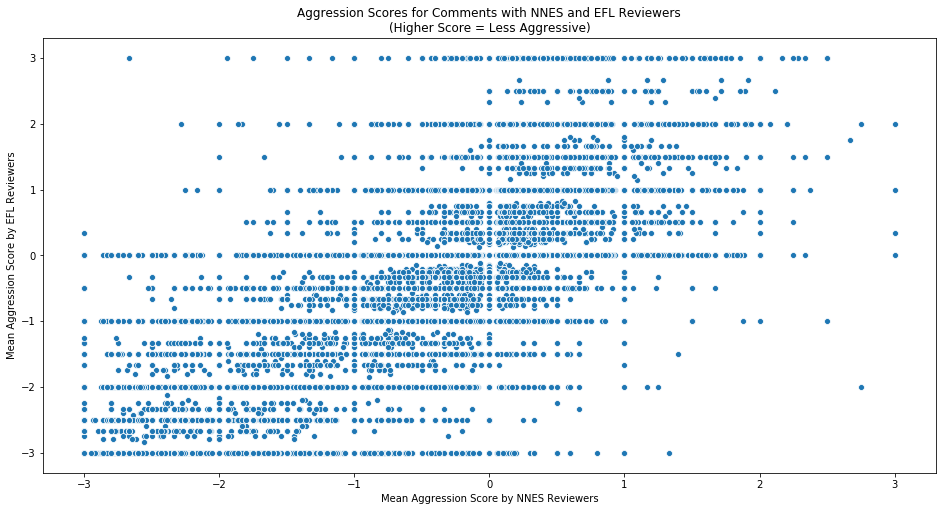

In [27]:
# plotting and saving 
fig = plt.figure(figsize=(16,8))
sns.scatterplot(data=df_scatter_ready, x='aggression_score_nnes', y='aggression_score_efl')
plt.title('Aggression Scores for Comments with NNES and EFL Reviewers\n(Higher Score = Less Aggressive)')
plt.xlabel('Mean Aggression Score by NNES Reviewers')
plt.ylabel('Mean Aggression Score by EFL Reviewers')
plt.savefig('./figures/fig1.png')
plt.show()

## Simple Linear Regression

We can perform simple linear regression in the same spirit of the above chart, to lend additional context to the conclusions we draw from the scatter plot. We simply adjust the format of the data, and perform the test below, and then output key statistics.

In [201]:
# reformat data
x = df_scatter_ready['aggression_score_nnes'].to_numpy().reshape(-1,1)
y = df_scatter_ready['aggression_score_efl'].to_numpy().reshape(-1,1)

# execute and summarize
mdl = sm.OLS(x, y)
result = mdl.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.464
Model:                            OLS   Adj. R-squared (uncentered):              0.464
Method:                 Least Squares   F-statistic:                          6.076e+04
Date:                Wed, 21 Oct 2020   Prob (F-statistic):                        0.00
Time:                        22:51:05   Log-Likelihood:                         -54054.
No. Observations:               70214   AIC:                                  1.081e+05
Df Residuals:                   70213   BIC:                                  1.081e+05
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.5122      0.002    246.486      0.000       0.508       0.516
==============================================================================
Omnibus:                    12289.001   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39595.196
Skew:                          -0.895   Prob(JB):                         0.00
Kurtosis:                       6.214   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Analysis Summary

We notice that mean NNES score on comments positively correlates with mean EFL score. Due to the volume of data, the chart does indicate a high number of outliers, but the correlation is clear, and appears to be strongly linear. The low p-value indicates statistically significant evidence of a non-zero relationship between our two groups, but note that the R-squared value does not indicate much of the variance in one group is explained by the other. 

It is clear that NNES and EFL reviews are not headed in wildly different directions. If comments begin to see higher or lower aggression ratings from EFL reviewers, respectively, then they see the same trend in NNES reviewers (and vice versa). The graph indicates that outside of outliers, the mean scores by the NNES and EFL reviewers are closely related, in a positive way. This suggests that there is not much of a difference in the way EFL and NNES reviewers perceive aggressiveness in Wikipedia comments, and that their linguistic background does not play a big role in their decision-making in this project. It is still notable that an extremely small percent of comments have at least 1 NNES reviewer, and even those that do often have a small minority thereof. 

*__Bottom line:__* the reviewing body is heavily skewed towards primarily English-speaking reviewers, but the difference in behavior beween these reviewers and NNES ones is not significant enough to suggest that the resulting annotations are made biased by one of these linguistic parties.


# Analysis 2: Divisiveness Over Time

## Motivation & Objective

There is a common awareness that debate, politics, social issues, and other discussions have experienced increasing degrees of divisiveness. That is, all mainstream discussion topics bear the brunt of increased partisanship, polarization, toxicity, and conflict. It seems that as the years have gone by, we have gotten worse at hosting discussions that are non-adversarial in nature and that can feasibly have a resolved outcome. Let us  broadly refer to this feeling as "increased toxicity over time." 

If all discussion feels more toxic over time, maybe the comments in this data are, too. Reviewers may catch and reflect this trend in their annotations. So, we first want to determine whether reviewers (in general) feel as though toxicity has risen over time. This will tell us whether the discussions on Wikipedia worsened across the years. 

Then, we can check whether the reviewers themselves grow more divided as they transition from scoring older to newer comments. Annotations were not made over a many-year process like the comments themselves. The acquisition and work of reviewers took place in a nearly-fixed, later period. So, this question will indicate whether reviewers score in a more polarized way, as they get closer to the increasingly polarized discussions of their time. Naturally, all work will be done on the Toxicity data, which deals in discussion health.

## Toxicity Trends

Analyzing overall toxicity over time has two forms. First, after grouping by year, we can compute the average proportion of annual comments that were flagged as toxic by reviewers. The `toxicity` column just has 0s for non-toxic comments and 1s for toxic comments. The column's average, then, is just the proportion of 1s, or comments that were seen as toxic. The resulting visualization is saved in `figures/` as `fig2.png`. 


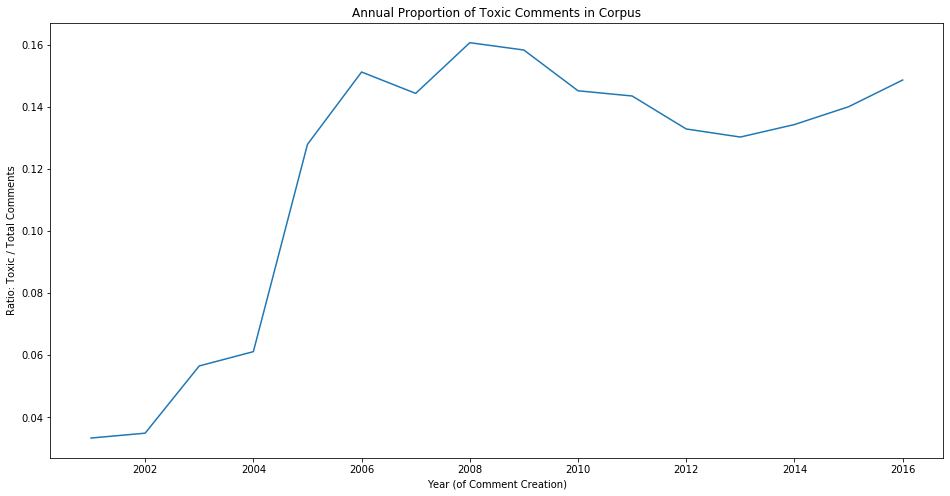

In [45]:
# filter out missing toxicity scores
df_tox = df_tox.dropna(subset=['toxicity', 'toxicity_score'])

# perform average aggregation
df_grouped_years = df_tox.groupby('year').mean()

# plot toxicity flag over time, and save
fig = plt.figure(figsize=(16,8))
plt.plot(df_grouped_years.index, df_grouped_years['toxicity'])
plt.title('Annual Proportion of Toxic Comments in Corpus')
plt.xlabel('Year (of Comment Creation)')
plt.ylabel('Ratio: Toxic / Total Comments')
plt.savefig('./figures/fig2.png')
plt.show()

Secondly, it is prudent to look at the average toxicity __score__ per year, too. The score is on a [-2,2] scale, with -2 being very toxic and 0 being neutral. We may see an upside-down/flipped version of the above plot (i.e., the positive proportion of toxic comments). But while the toxicity flag is a binary response, the toxicity score is the degree of toxicity. So, this chart tells us __how toxic__ comments were (on average) each year. It is saved in `figures/` as `fig3.png`.

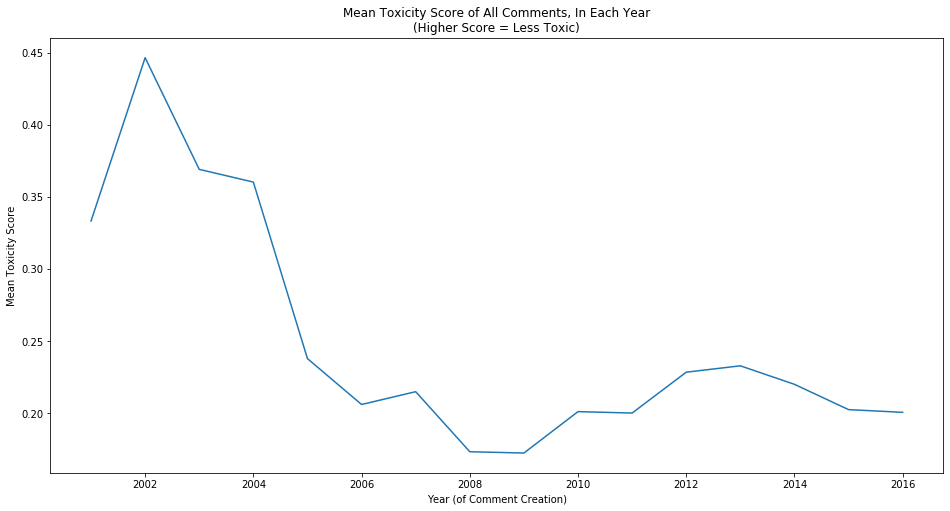

In [46]:
# plot toxicity score over time, and save
fig = plt.figure(figsize=(16,8))
plt.plot(df_grouped_years.index, df_grouped_years['toxicity_score'])
plt.title('Mean Toxicity Score of All Comments, In Each Year\n(Higher Score = Less Toxic)')
plt.xlabel('Year (of Comment Creation)')
plt.ylabel('Mean Toxicity Score')
plt.savefig('./figures/fig3.png')
plt.show()

## Disagreement Among Reviewers

Without diving into complicated statistical tests for which certain assumptions may not be available, we need to categorize disagreement over each year's worth of comments. If reviewers strongly agree on a comment, its score will be closer to the extremes (-2 or 2) on average, and if they disagree, the scores will cancel out to result in an average score closer to 0 (later, we discuss the flaws of this approach). So, we group by year and comment. Then, for each year, we compute each comment's average score.

In [39]:
# mean toxicity score per comment, per year, with indices reset for plotting
df_violin_ready = df_tox.groupby(['year', 'comment']).mean()
df_violin_ready = df_violin_ready.reset_index()

Now we have average scores, for each comment, in each year. Each year can now have a violin plot of its scores; each violin figure will represent the distribution of average toxicity scores (one average score per comment) in each year. Combining these figures into one axis will show us how the distribtion has changed over time. The figure is saved in `figures/` as `fig4.png`. 

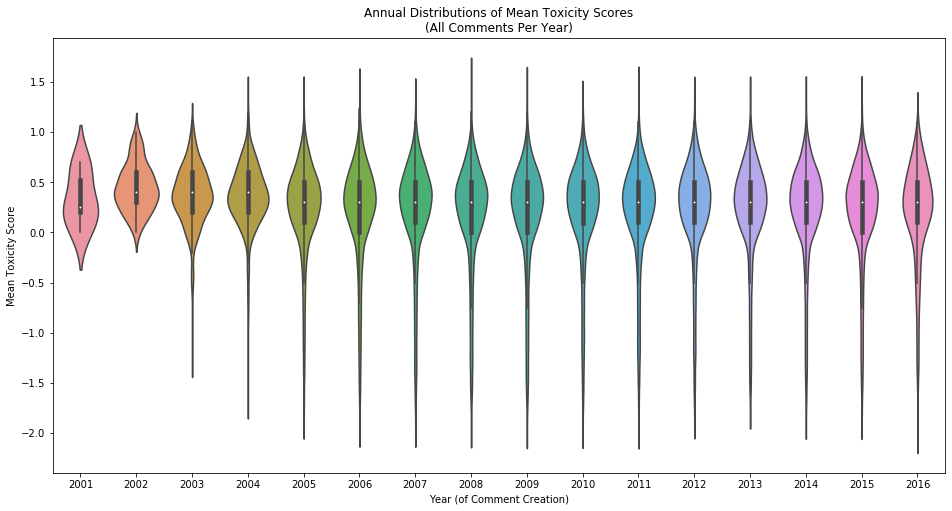

In [49]:
fig = plt.figure(figsize=(16,8))
sns.violinplot(data=df_violin_ready, x='year', y='toxicity_score')
plt.title('Annual Distributions of Mean Toxicity Scores\n(All Comments Per Year)')
plt.xlabel('Year (of Comment Creation)')
plt.ylabel('Mean Toxicity Score')
plt.savefig('./figures/fig4.png')
plt.show()

## Analysis Summary

The two line charts indicate two key themes: toxic comments (as judged by reviewers) were on the rise over the 16-year period, and the comments were getting more and more toxic (again, as judged by reviewers) in that same timeframe. So there is definitely a pattern that suggests discussion conditions have become more unfriendly and extreme as time has gone on. 

Remember that scores on extreme ends of disagreement, will average to 0. However, if many scores agree on a neutral rating, that will also average to 0. So while the violin plots show that comments are concentrated near a mean score of 0 in the early years, and only deviate slightly up to 2016, they do not account for the vast amounts of neutral comments that received near-unanimous ratings. They also do not account for the unequal reviewer counts per comment.  

That said, it is clear that outliers were more of an issue in later years, as evidenced by the growing tails. So, interestingly, there are more comments with high levels of agreement in extreme directions (very toxic or very friendly) in later years, and most of these outliers are in the very-toxic direction.  

*__Bottom line__*: Comments do seem to grow more toxic over time, and reviewers identify these comments accordinly: that is, with more extreme scores and greater agreement. While this indicates __a possible bias_ against newer topics of discussion, we find insufficient evidence to say that reviewers are becoming more discordant/divided when judging newer comments.


# Further Implications

*Which, if any, of these demo applications would you expect the Perspective API—or any model trained on the Wikipedia Talk corpus—to perform well in? Why?*

I anticipate that applications such as Hot Topic, Toxicity Timeline, and Wikipedia Detox to work well with the Perspective API/similar models. The role of these applications (broadly) is to identify sources of contention and toxicity, or document the toxicity in chronological format. Even with any flaws for the model backend, these tools are lightweight additions to the user experience: they do not manipulate content or demand changes in user behavior. They simply document and inform users of their backend judgment of certain content (which admittedly causes user preconceptions about said content), and leave space for users to deliberate over how they want to view, discuss, or proceed. With sufficient data, there will be minimal adverse effects, and even with model issues, there is no direct/ongoing harm to the user experience.

*Which, if any, of these demo applications would you expect the Perspective API to perform poorly in? Why?
What are some other contexts or applications where you would expect the Perspective API to perform particularly well, or particularly poorly? Why?*

I anticipate that applications like Comment Filter, Behave!, and Authorship Feedback will perform poorly. Their core functionality involves filtering content based on toxicity, transforming user contributions based on perceived toxicity, or providing interactive judgment on user contributions. In this case, model flaws may be exacerbated; without a lot of attention or deliberation, a bad model may further marginalize or erase undeserving content, or allow truly toxic material to continue perpetuating user harm. Additionally, these services are simply more "annoying"; they are more likely to frustrate users by adding hurdles to the easy access/view/contribution of content, and will be especially frustrating if the model behind them is not fair and accurate. Rather than pre-emptively erasing or altering content, they might benefit from documenting or presenting findings to users less invasively. 

*What are some kinds of hostile speech that would be difficult to accurately detect using the approach used to train the Perspective API models?*

There is a broad category of hostile speech, sarcasm, that is likely difficult for models to categorize appropriately (even if reviewers label them appropriately in the data). For instance, say User A comments in favor of Politician P because they have faith in their climate change plans. And, say User B has more background about P and knows this to be false, but sardonically comments "yes, P is famously known for their belief in climate change". A model may very well find no bad language or tonal issues in this sarcastic reply. But damage has been done; the situation has already turned towards demeaning intelligence, unclear sarcastic exchanges, and unproductive comments. With more complex examples, models' weaknesses with respect to sarcasm will become even clearer, and a lot of toxicity that develops from initial sarcasm will remain unchecked. A lot of humor that deals in two-faced statements, hidden meanings, and the like, will similarly stump Perspective API and its contemporaries.